# Using the `ncbi.datasets` python library to navigate NCBI assembly data

The `ncbi.datasets` python library can be used to query NCBI datasets and navigate through the results quickly within python. 

## Getting started

First, let's import the python modules we'll use.  Be sure you have first installed the requirements in 'requirements.txt' into your virtual environment.

In [1]:
import sys
import zipfile
import pandas as pd
from pprint import pprint
from datetime import datetime
from collections import defaultdict, Counter
from IPython.display import display

import matplotlib.pyplot as plt
plt.style.use('ggplot')

try:
    import ncbi.datasets
except ImportError:
    print('ncbi.datasets module not found. To install, run `pip install ncbi-datasets-pylib`.')

## Genome summaries

Genome summaries include all the metadata you'll need, and can be accessed in four ways:
1. accession: an NCBI Assembly accession
2. organism: an organism or a taxonomical group name 
3. taxid: using an NCBI Taxonomy identifier, at any level.
4. BioProject: using an NCBI BioProject accession

First, we'll need an api object specific to retrieving assembly descriptors.  To see all the possible API instances, [visit the documentation on GitHub](https://github.com/ncbi/datasets/tree/master/client_docs/python#documentation-for-api-endpoints)

In [1]:
## start an api_instance 
api_instance = ncbi.datasets.GenomeApi(ncbi.datasets.ApiClient())

### Genome summaries by accession

Let's start with the simplest case.  Say you already know the NCBI Assembly accession, for example, for the latest human reference genome assembly (GRCh38), `GCF_000001405.39`.  Using the `assembly_descriptors_by_accessions()` method, we'll get back a `V1alpha1AssemblyDatasetDescriptors` object ([documented here](https://github.com/ncbi/datasets/blob/master/client_docs/python/docs/V1alpha1AssemblyDatasetDescriptors.md)) (a mouthful we know).  The various fields in the response are attributes of the object.

Let's see this in practice.

In [1]:
assembly_accessions = ['GCF_000001405.39'] ## needs to be a full accession.version

genome_summary = api_instance.assembly_descriptors_by_accessions(assembly_accessions, limit='all')

type(genome_summary)


ncbi.datasets.models.v1alpha1_assembly_metadata.V1alpha1AssemblyMetadata

`genome_summary` contains metadata about the genome assembly and the total count of results in JSON format.

In [1]:
print(genome_summary)

{'assemblies': [{'assembly': {'annotation_metadata': {'file': [{'estimated_size': '49900325',
                                                                'type': 'GENOME_GFF'},
                                                               {'estimated_size': '1315360259',
                                                                'type': 'GENOME_GBFF'},
                                                               {'estimated_size': '118242932',
                                                                'type': 'RNA_FASTA'},
                                                               {'estimated_size': '26280470',
                                                                'type': 'PROT_FASTA'},
                                                               {'estimated_size': '41033486',
                                                                'type': 'GENOME_GTF'}],
                                                      'name': 'NCBI Annotation '
          

In [1]:
print(f"Number of assemblies: {genome_summary.total_count}" )

Number of assemblies: 1


In [1]:
## print other information 
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    print(
        assembly.assembly_accession,
        assembly.assembly_level,
        len(assembly.chromosomes),
        assembly.submission_date,
        sep='\t')

GCF_000001405.39	Chromosome	26	2019-02-28


### Genome summaries by organism or tax group name 

Now let's say you only know the name of the organism for which you want to retrieve assembly information.

In [1]:
## a few examples to try 
# tax_name = 'mammals'
# tax_name = 'birds'
# tax_name = 'butterflies'
tax_name = 'primates'

genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon=tax_name,
    limit='all')

In [1]:
print(f"Number of assemblies in the group '{tax_name}': {genome_summary.total_count}")

Number of assemblies in the group 'primates': 348


#### Assemblies organized by GenBank/RefSeq
Now we can analyze the results and organize by GenBank and RefSeq, and make a nice tabular output and pie-chart of the results.

In [1]:
assm_counter = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.assembly_accession[:3] == 'GCA':
        assm_counter['GenBank'] += 1
    elif assembly.assembly_accession[:3] == 'GCF':
        assm_counter['RefSeq'] += 1
    
print(assm_counter)

Counter({'GenBank': 318, 'RefSeq': 30})


,count
RefSeq,30
GenBank,318


<AxesSubplot:title={'center':'Assemblies by type'}, ylabel='count'>

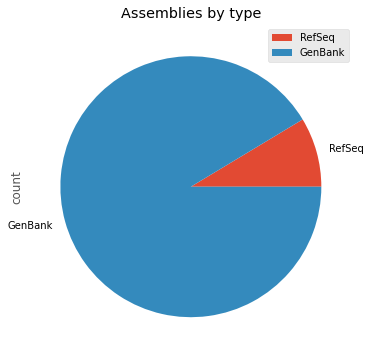

In [1]:
df = pd.DataFrame.from_dict(assm_counter, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by type')

#### Assemblies organized by assembly level
Alternatively, we can organize by the assembly level (scaffold, contig or choromosome).

In [1]:
assm_level = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    assm_level[assembly.assembly_level] += 1
    
print(assm_level)

Counter({'Scaffold': 214, 'Contig': 68, 'Chromosome': 66})


,count
Scaffold,214
Chromosome,66
Contig,68


<AxesSubplot:title={'center':'Assemblies by level'}, ylabel='count'>

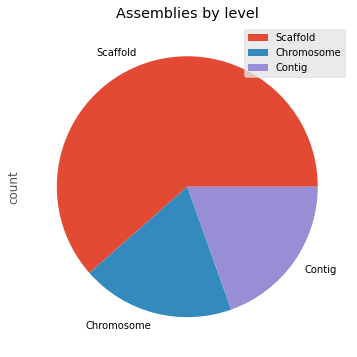

In [1]:
df = pd.DataFrame.from_dict(assm_level, orient='index', columns=['count'])
display(df)
df.plot(kind='pie', y='count', figsize=(6,6), title='Assemblies by level',)

#### Assemblies grouped and counted by annotation release number

All RefSeq assemblies are annotated and each annotation release is numbered, starting from 100. A quick way to check if the latest annotation is the first time an assembly for that organism was annotated is to check the annotation release number. Anything above 100 can be interpreted to have been through multiple annotations. 

For example, in the analysis shown below, the human assembly has an annotation release number 109 indicating that a human assembly was annotated multiple times. On the other hand, the silvery gibbon assembly has an annotation release number of 100 indicating that this is the first time an assembly from this organism was annotated. 

In [1]:
## out of the 28 RefSeq assemblies, how many have been annotated more than once? 
annot_counter = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.assembly_accession.startswith('GCF') and assembly.annotation_metadata and assembly.annotation_metadata.release_number:
        rel = int(assembly.annotation_metadata.release_number.split('.')[0])
        annot_counter[rel] += 1
pprint(annot_counter)

Counter({100: 9, 101: 8, 103: 3, 105: 3, 102: 3, 104: 2, 109: 1})


<AxesSubplot:>

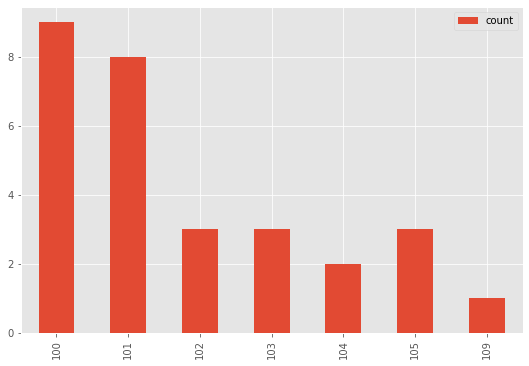

In [1]:
df = pd.DataFrame.from_dict(annot_counter, orient='index', columns=['count']).sort_index()
df.plot(kind='bar', y='count', figsize=(9,6))

#### Assemblies organized by annotation release number

In [1]:
annot_list = defaultdict(list)
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if assembly.assembly_accession.startswith('GCF') and assembly.annotation_metadata:
        rel = assembly.annotation_metadata.release_number
        annot_list[rel].append(assembly.assembly_accession + ' ' + assembly.org.title)
pprint(annot_list)

defaultdict(<class 'list'>,
            {'100': ['GCF_000955945.1 sooty mangabey',
                     'GCF_000951045.1 drill',
                     'GCF_003255815.1 gelada',
                     'GCF_000951035.1 Colobus angolensis palliatus',
                     "GCF_009764315.1 Francois's langur",
                     'GCF_001698545.1 black snub-nosed monkey',
                     'GCF_001604975.1 Panamanian white-faced capuchin',
                     'GCF_009761245.1 Tufted capuchin',
                     "GCF_000956105.1 Coquerel's sifaka"],
             '101': ['GCF_009828535.2 silvery gibbon',
                     'GCF_000364345.1 crab-eating macaque',
                     'GCF_000956065.1 pig-tailed macaque',
                     'GCF_007565055.1 golden snub-nosed monkey',
                     "GCF_000952055.2 Ma's night monkey",
                     'GCF_000235385.1 Bolivian squirrel monkey',
                     'GCF_000164805.1 Philippine tarsier',
                     'GCF

### Genomes summaries by taxid
Finally, you may want to query for genome assemblies by NCBI Taxonomy ID.  

In [1]:
# taxid = 8782 ## birds
# taxid = 7898 ## ray-finned fish
taxid = 37572 ## butterflies

genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon=taxid,
    limit='all',
    filters_refseq_only=True)

In [1]:
print(f"Number of assemblies: {genome_summary.total_count}")

Number of assemblies: 8


In [1]:
## count number of GenBank and RefSeq assemblies
## all are RefSeq assemblies because 'filters_refseq_only=True' above
assm_counter = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    assm_counter[assembly.assembly_accession[:3]] += 1
    
print(assm_counter)

Counter({'GCF': 8})


#### Group assemblies by annotation date

In [1]:
annot_rel_dates = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if not assembly.annotation_metadata:
        continue
    rel_date = datetime.strptime(assembly.annotation_metadata.release_date, '%b %d, %Y')
    rel_year = datetime.strftime(rel_date, '%Y')
    annot_rel_dates[rel_year] += 1
pprint(sorted(annot_rel_dates.items()))

[('2015', 3), ('2017', 1), ('2018', 2), ('2020', 2)]


<AxesSubplot:>

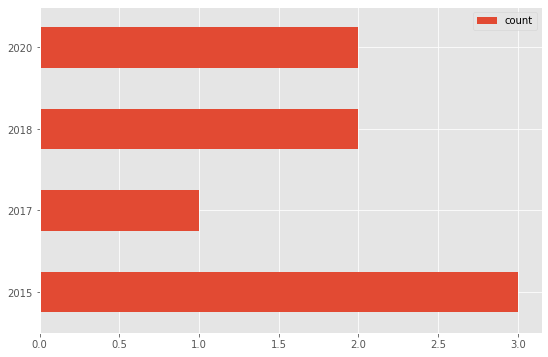

In [1]:
df = pd.DataFrame.from_dict(annot_rel_dates, orient='index', columns=['count']).sort_index()
df.plot(kind='barh', y='count', figsize=(9,6))

In [1]:
genome_table = {}
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    if not assembly.annotation_metadata:
        continue
    n_chr = len(assembly.chromosomes) if assembly.assembly_level == 'Chromosome' else None
    genome_table[assembly.assembly_accession] = {
        'assm_name': assembly.display_name,
        'annot_rel_date': assembly.annotation_metadata.release_date,
        'annot_rel_num': assembly.annotation_metadata.release_number,
        'assm_level': assembly.assembly_level,
        'num_chromosomes': n_chr,
        'contig_n50': assembly.contig_n50,
        'seq_length': assembly.seq_length,
        'submission_date': assembly.submission_date }
df = pd.DataFrame.from_dict(genome_table, orient='columns')
display(df)

,GCF_009731565.1,GCF_902806685.1,GCF_900239965.1,GCF_002938995.1,GCF_000836235.1,GCF_000836215.1,GCF_001298355.1,GCF_001856805.1
assm_name,Dplex_v4,iAphHyp1.1,Bicyclus_anynana_v1.2,ASM293899v1,Pxut_1.0,Ppol_1.0,Pap_ma_1.0,P_rapae_3842_assembly_v2
annot_rel_date,"Feb 24, 2020","Jun 05, 2020","Feb 16, 2018","Oct 03, 2018","Jul 31, 2015","Jul 30, 2015","Oct 28, 2015","Aug 08, 2017"
annot_rel_num,100,100,100,100,100,100,100,100
assm_level,Chromosome,Chromosome,Scaffold,Scaffold,Scaffold,Scaffold,Scaffold,Scaffold
num_chromosomes,31,30,None,None,None,None,None,None
contig_n50,108026,2012761,78697,254123,128246,47768,92238,54957
seq_length,248676414,408137179,475399557,357124929,243890167,227005758,278421261,245871251
submission_date,2019-12-11,2020-02-22,2018-01-02,2018-02-23,2015-02-02,2015-02-02,2015-09-28,2016-10-16


## Genome assembly downloads
So far, we have looked at interacting with genome summaries, which describe the essential metadata for genome assemblies. In addition to metadata, the Datasets API can be used to download a genome dataset consisting of genome, transcript, and protein sequences in FASTA format, as well as annotation data in gff3, gtf, and GenBank flat file formats.

To illustrate, let's start by downloading a genome dataset including mitochondrial genome sequence and all protein sequences for the latest human genome assembly, GRCh38.

In [1]:
assembly_accessions = ['GCF_000001405.39']
chromosomes = ['MT']
exclude_sequence = False
include_annotation_type = ['PROT_FASTA']

api_response = api_instance.download_assembly_package(
    assembly_accessions,
    chromosomes=chromosomes,
    exclude_sequence=exclude_sequence,
    include_annotation_type=include_annotation_type,
    # Because we are streaming back the results to disk, 
    # we should defer reading/decoding the response
    _preload_content=False
)

with open('human_assembly.zip', 'wb') as f:
    f.write(api_response.data)


Now we'll unzip the downloaded zip archive. All data is contained in ncbi_dataset/data. Data that is specific to the human reference genome, GRCh38, is contained within a subdirectory named with that assembly accession, GCF_000001405.39. 
The data directory contains five files:
 1. The assembly data report contains assembly information like sequence names,  NCBI accessions, UCSC-style chromosome names, and annotation statistics (gene counts). Note that this file is directly under the data directory and not in the subdirectory named with the assembly accession. When the genome dataset contains data for multiple assemblies, genome assembly metadata for all of these assemblies is contained in the `assembly_data_report.jsonl` file
 2. The sequence report (`sequence_report.jsonl`) contains a list of the sequences that comprise the GRCh38 assembly
 3. The nucleotide sequence in FASTA (nucleotide) format for the one "chromosome" we requested: `chrMT.fna`
 4. All protein sequences in FASTA (amino acid) format: `protein.faa`
 5. And finally, a dataset catalog file (`dataset_catalog.json`) that describes the contents of the archive, to aid in programmatic access.
Read more about the contents in the [download assembly command
 section of the documentation](https://www.ncbi.nlm.nih.gov/datasets/docs/command-line-assembly/).  

In [1]:
!unzip -v human_assembly.zip

Archive:  human_assembly.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 11-16-2020 13:15 bc3c97af  README.md
    1044  Defl:N      573  45% 11-16-2020 13:15 875a7b5b  ncbi_dataset/data/assembly_data_report.jsonl
   16834  Defl:N     5379  68% 11-16-2020 13:15 932c3ae8  ncbi_dataset/data/GCF_000001405.39/chrMT.fna
85815507  Defl:N 26280452  69% 11-16-2020 13:15 04376109  ncbi_dataset/data/GCF_000001405.39/protein.faa
     211  Defl:N      166  21% 11-16-2020 13:15 28e03896  ncbi_dataset/data/GCF_000001405.39/sequence_report.jsonl
     499  Defl:N      211  58% 11-16-2020 13:15 2cc86c6a  ncbi_dataset/data/dataset_catalog.json
--------          -------  ---                            -------
85834756         26287165  69%                            6 files


## Using genome summary data to request genome datasets

When you need to download a genome dataset for a particular taxonomic group, you'll need to first get the list of genome assembly accessions, then you can query by accession to download the data that you're interested in.

In this example, we'll download a genome dataset for a list of bird RefSeq genomes annotated in 2020.

1. Fetch a list of RefSeq assembly accessions for all rodent genomes using `assembly_descriptors_by_taxid` 
2. Filter assemblies that were annotated in 2020
3. Download data, but in this case, retrieve a dehydrated zip archive that can be rehydrated later to obtain the sequence data itself.

In [1]:
genome_summary = api_instance.assembly_descriptors_by_taxon(
    taxon=9989, ## Rodents taxid
    limit='all',
    filters_refseq_only=True)

print(f'Number of assemblies: {genome_summary.total_count}')

Number of assemblies: 30


In [1]:
annots_by_year = Counter()
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    annot_year = int(assembly.annotation_metadata.release_date.split(' ')[-1])
    annots_by_year[annot_year] += 1
    
print(f'Assemblies grouped by year of annotation')
pprint(sorted(annots_by_year.items()))

Assemblies grouped by year of annotation
[(2015, 3), (2016, 4), (2017, 5), (2018, 4), (2019, 5), (2020, 9)]


In [1]:
rodents_annotated_in_2020_accs = []
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    annot_year = int(assembly.annotation_metadata.release_date.split(' ')[-1])
    if annot_year == 2020:
        rodents_annotated_in_2020_accs.append(assembly.assembly_accession)
        
print('Rodent assemblies that were annotated in 2020:')
print(f'{", ".join(rodents_annotated_in_2020_accs)}')

Rodent assemblies that were annotated in 2020:
GCF_003676075.2, GCF_012274545.1, GCF_000223135.1, GCF_003668045.3, GCF_903995425.1, GCF_004664715.2, GCF_011762505.1, GCF_000001635.27, GCF_011064425.1


In [1]:
assm_table = {}
for assembly in map(lambda d: d.assembly, genome_summary.assemblies):
    annot_year = int(assembly.annotation_metadata.release_date.split(' ')[-1])
    if annot_year == 2019:
        n_chr = len(assembly.chromosomes) if assembly.assembly_level == 'Chromosome' else None
        assm_table[assembly.assembly_accession] = {
            'assm_name': assembly.display_name,
            'org_name': assembly.org.title,
            'sci_name': assembly.org.sci_name,
            'annot_rel_date': assembly.annotation_metadata.release_date,
            'annot_rel_num': assembly.annotation_metadata.release_number,
            'assm_level': assembly.assembly_level,
            'num_chromosomes': n_chr,
            'contig_n50': assembly.contig_n50,
            'seq_length': assembly.seq_length,
            'submission_date': assembly.submission_date }
df = pd.DataFrame.from_dict(assm_table, orient='columns')
display(df)

,GCF_004785775.1,GCF_900095145.1,GCF_900094665.1,GCF_008632895.1,GCF_000622305.1
assm_name,NIH_TR_1.0,PAHARI_EIJ_v1.1,CAROLI_EIJ_v1.1,UCSF_Mcou_1,S.galili_v1.0
org_name,Grammomys surdaster,shrew mouse,Ryukyu mouse,southern multimammate mouse,Upper Galilee mountains blind mole rat
sci_name,Grammomys surdaster,Mus pahari,Mus caroli,Mastomys coucha,Nannospalax galili
annot_rel_date,"Apr 18, 2019","Jun 14, 2019","Jun 07, 2019","Oct 18, 2019","Jun 05, 2019"
annot_rel_num,100,101,101,100,102
assm_level,Scaffold,Chromosome,Chromosome,Chromosome,Scaffold
num_chromosomes,None,25,22,4,None
contig_n50,51731,29465,30917,30483,30353
seq_length,2412664998,2475012951,2553112587,2507168619,3061408210
submission_date,2019-04-12,2017-04-28,2017-04-28,2019-09-24,2014-06-05


#### Download package for selected assemblies

For the assemblies collected above, download a dehydrated data package (hydrated=DATA_REPORT_ONLY).  This will only contain the data report, and defer collection of nucleotide and protein sequence data until rehydration.

In [1]:
%%time

print(f'Download a dehydrated package for {rodents_annotated_in_2020_accs}, with the ability to rehydrate with the CLI later on.')
api_response = api_instance.download_assembly_package(
    rodents_annotated_in_2020_accs,
    exclude_sequence=True,
    hydrated='DATA_REPORT_ONLY',
    _preload_content=False )

zipfile_name = 'rodent_genomes.zip'
with open(zipfile_name, 'wb') as f:
    f.write(api_response.data)

print('Download complete')

Download a dehydrated package for ['GCF_003676075.2', 'GCF_012274545.1', 'GCF_000223135.1', 'GCF_003668045.3', 'GCF_903995425.1', 'GCF_004664715.2', 'GCF_011762505.1', 'GCF_000001635.27', 'GCF_011064425.1'], with the ability to rehydrate with the CLI later on.
Download complete
CPU times: user 12.9 ms, sys: 6.34 ms, total: 19.3 ms
Wall time: 84.2 ms


In [1]:
!unzip -v {zipfile_name}

caution:  not extracting; -d ignored
Archive:  rodent_genomes.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
     661  Defl:N      384  42% 11-16-2020 16:38 bc3c97af  README.md
   13280  Defl:N     3383  75% 11-16-2020 16:38 76d1b5cf  ncbi_dataset/data/assembly_data_report.jsonl
    1592  Defl:N      262  84% 11-16-2020 16:38 c7576a15  ncbi_dataset/data/dataset_catalog.json
    1645  Defl:N      366  78% 11-16-2020 16:38 1057cdf0  ncbi_dataset/fetch.txt
--------          -------  ---                            -------
   17178             4395  74%                            4 files


#### Rehydrate data package
To rehydrate, use the [NCBI Datasets command-line application](https://www.ncbi.nlm.nih.gov/datasets/docs/command-line-start/). For example, the following commands illustrate the process for Linux 
```
curl -o datasets 'https://ftp.ncbi.nlm.nih.gov/pub/datasets/command-line/LATEST/linux-amd64/datasets'  
chmod +x datasets
# specify the directory that contains the extracted zip archive after the directory flag
./datasets rehydrate --directory rodent_genomes/
```
